(c) 2023 Manuel Razo. This work is licensed under a [Creative Commons
Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/).
All code contained herein is licensed under an [MIT
license](https://opensource.org/licenses/MIT).

In [2]:
# Load project package
@load_pkg BayesFitness

import Revise
import Suppressor
# Import project package
import BayesFitness
# Import library to list files
import Glob
# Import package to save chains into memory
import BSON

# Import package to handle DataFrames
import DataFrames as DF
import CSV
import XLSX

# Import basic statistical functions
import StatsBase
import Random

# Import basic math
import LinearAlgebra

# Import libraries relevant for MCMC
import Turing
import MCMCChains

# Load CairoMakie for plotting
using CairoMakie
import ColorSchemes
import Makie
# Activate backend
CairoMakie.activate!()

# Set PBoC Plotting style
BayesFitness.viz.pboc_makie!()

# Bayesian inference of adaptive mutants fitness

## The fitness model

`[explanation here]`

## Loading the data

Let's begin by loading the data.

In [3]:
# Load data
df = CSV.read("$(git_root())/data/big_batch/tidy_counts.csv", DF.DataFrame)

first(df, 5)

Row,BCID_x,bc_merged,barcode,barcode_lowcomplexity,barcode_highcomplexity,BCID_y,barcode_fasta,source_publication,cloneID,cloneID_new,evolution_condition,ancestor,class,ploidy,ploidy_new,gene,type,additional_muts,1D_Fitness_Li2019,1D_Error_Li2019,2D_Fitness_Li2019,2D_Error_Li2019,3D_Fitness_Li2019,3D_Error_Li2019,5D_Fitness_Li2019,5D_Error_Li2019,FerPerHour_Li2019,ResPerHour_Li2019,StaPerHour_Li2019,name,count,rep,timepoint,time,batch,hub,perturbation,neutral
,Int64,String,String,String31,String,Int64,String,String15,String31,String?,String7,String15,String31,String15,String15,String31,String?,String?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,String,Int64,String3,String3,Int64,String7,String7,String15,Bool
1,0,GAGTGAAACATGAATGGTATTCATCATGATCAATCTACAAAAATATTTAATG,TGATCAATCTACAAAAATATTTAATG_GAGTGAAACATGAATGGTATTCATCA,TGATCAATCTACAAAAATATTTAATG,GAGTGAAACATGAATGGTATTCATCA,0,GAGTGAAACATGAATGGTATTCATCATGATCAATCTACAAAAATATTTAATG,This_study,missing,EVO2D_IRA1_MIS_rearray_Plate1-A1,Evo2D,IRA1_MIS,missing,missing,diploid,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,Batch1_1Day-T0_combined,53,R1,T0,0,Batch1,1Day,28,false
2,1,ACTCTAACGTGTAACTAATTTTGAGTCCGCCAATCCCGAACCCCGTTTCGCC,CCGCCAATCCCGAACCCCGTTTCGCC_ACTCTAACGTGTAACTAATTTTGAGT,CCGCCAATCCCGAACCCCGTTTCGCC,ACTCTAACGTGTAACTAATTTTGAGT,1,ACTCTAACGTGTAACTAATTTTGAGTCCGCCAATCCCGAACCCCGTTTCGCC,Aggeli2020,gpb2_evo1_plate9_H8,gpb2_evo1_plate9_H8,Evo2D,GPB2,adaptive_haploids,Haploid,Haploid,missing,Other,DOP1-NON_SYNONYMOUS_CODING; SMD2-NON_SYNONYMOUS_CODING; YDL180W-DOWNSTREAM; LAS21-UPSTREAM,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,Batch1_1Day-T0_combined,1213,R1,T0,0,Batch1,1Day,28,false
3,2,ATGGGAACACGGAATGATCTTTTATTGACAGAAAAGCCAAATGGATTTACCG,GACAGAAAAGCCAAATGGATTTACCG_ATGGGAACACGGAATGATCTTTTATT,GACAGAAAAGCCAAATGGATTTACCG,ATGGGAACACGGAATGATCTTTTATT,2,ATGGGAACACGGAATGATCTTTTATTGACAGAAAAGCCAAATGGATTTACCG,This_study,missing,EVO3D_TCG_rearray_Plate1-A4,Evo3D,CYR1,missing,missing,diploid,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,Batch1_1Day-T0_combined,17,R1,T0,0,Batch1,1Day,28,false
4,3,TACTAAATAAGTAAGGGAATTCTGTTCCAACAAAACACAAATCTGTTGTGTA,CCAACAAAACACAAATCTGTTGTGTA_TACTAAATAAGTAAGGGAATTCTGTT,CCAACAAAACACAAATCTGTTGTGTA,TACTAAATAAGTAAGGGAATTCTGTT,3,TACTAAATAAGTAAGGGAATTCTGTTCCAACAAAACACAAATCTGTTGTGTA,This_study,missing,EVO2D_IRA1_NON_rearray_Plate1-A1,Evo2D,IRA1_NON,missing,missing,diploid,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,Batch1_1Day-T0_combined,19,R1,T0,0,Batch1,1Day,28,false
5,4,ATGACAAACTTTAAATAATTTAATTGTATCGAAACCCAAAGAGATTTAATCG,TATCGAAACCCAAAGAGATTTAATCG_ATGACAAACTTTAAATAATTTAATTG,TATCGAAACCCAAAGAGATTTAATCG,ATGACAAACTTTAAATAATTTAATTG,4,ATGACAAACTTTAAATAATTTAATTGTATCGAAACCCAAAGAGATTTAATCG,This_study,missing,EVO3D_IRA1_MIS_rearray_Plate1-C4,Evo3D,IRA1_MIS,missing,missing,haploid,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,Batch1_1Day-T0_combined,23,R1,T0,0,Batch1,1Day,28,false


# Bayesian  model using `Turing.jl`

Our objective for this section will be to implement the Bayesian model using the
probabilistic programing language that `Turing.jl` encodes.

`[explanation here]`

Let's define the model using the @model macro from `Turing.jl`

In [25]:
Turing.@model function fitness_mutants(
    logf_mut, logf_neutral, t, σ_sm, σ_σm, σ_st, σ_σt
)
    # Define parameter types
    s̲ₘ = Float32[]  # adaptive mutants fitness
    σ̲ₘ = Float32[]  # variance for adaptive mutants fitness likelihood

    s̲ₜ = Float32[]  # population mean fitness vector
    σ̲ₜ = Float32[]  # variance for population mean fitness likelihood

    ## Prior
    
    # Prior on adaptive mutants mean fitness
    s̲ₘ ~ Turing.filldist(Turing.Normal(0, σ_sm), size(logf_mut, 2))
    # Prior on variance for adaptive mutants fitness likelihood
    σ̲ₘ ~ Turing.filldist(
        Turing.truncated(Turing.Normal(0, σ_σm); lower=0.0 + eps()), 
        size(logf_mut, 2)
    )

    # Prior on the mean fitness
    s̲ₜ ~ Turing.filldist(Turing.Normal(0, σ_st), length(t))
    # Prior on error 
    σ̲ₜ ~ Turing.filldist(
        Turing.truncated(Turing.Normal(0, σ_σt); lower=0.0 + eps()), 
        length(t)
    )
    
    ## Likelihood

    # Population mean fitness
    
    # Loop through neutral lineages
    for j = 1:size(logf_neutral, 2)
        # Define non-infinity indexes
        idx = .!isinf.(logf_neutral[:, j])
        # Sample
        logf_neutral[idx, j] ~ Turing.MvNormal(
            -s̲ₜ[idx], LinearAlgebra.Diagonal(σ̲ₜ[idx] .^2)
        )
    end # for

    # Adaptive mutants fitness
    
     # Loop through mutants lineages
     for j = 1:size(logf_mut, 2)
        # Define non-infinity indexes
        idx = .!isinf.(logf_mut[:, j])
        # Sample
        logf_mut[idx, j] ~ Turing.MvNormal(
            s̲ₘ[j] .- s̲ₜ[idx], 
            LinearAlgebra.I(sum(idx)) .* (σ̲ₘ[j] .^2)
        )
    end # for

    return logf_mut, logf_neutral
end # @model function

fitness_mutants (generic function with 2 methods)

Let's now extract the data.

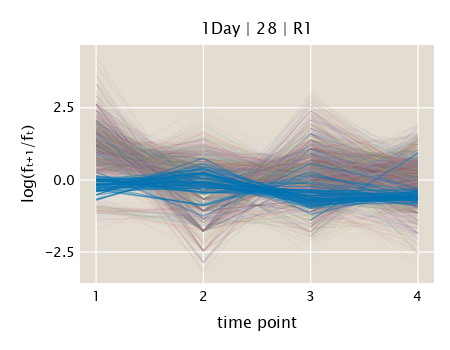

In [35]:
# Define information for data to extract
# batch = "Batch2"
# hub = "1Day"
# perturbation = "1.5"
# rep = "R1"
batch = "Batch1"
hub = "1Day"
perturbation = "28"
rep = "R1"


# Extract data. Note: The time T0 is common to all perturbations, thus, it must
# be extracted separately as a second condition.
data = df[
        (df.hub .== hub) .& 
        (df.batch .== batch) .&
        (df.perturbation .== perturbation) .&
        (df.rep .== rep)
    ,
:]

# Extract total counts per barcode
data_total = DF.combine(DF.groupby(data, :time), :count => sum)
# Add total count column to dataframe
DF.leftjoin!(data, data_total; on=:time)
# Add frequency column
DF.insertcols!(data, :freq => data.count ./ data.count_sum)

# Initialize dataframe to save the log freq changes
data_log = DF.DataFrame()

# Group data by barcode
data_group = DF.groupby(data, :barcode)

# Loop through each group
for d in data_group
    # Compute log change
    DF.append!(
        data_log, 
        DF.DataFrame(
            :barcode .=> first(d.barcode),
            :time => d.time[2:end],
            :logf => diff(log.(d.freq)),
            :neutral .=> first(d.neutral)
        )
    )
end # for

# Extract data for mutants
logf_mut = hcat(
    [
        Float32.(DF.sort(d, :time).logf)
        for d in DF.groupby(data_log[.!data_log.neutral, :], :barcode)
    ]...
)
# Extract data for neutral lineages
logf_neutral = hcat(
    [
        Float32.(DF.sort(d, :time).logf)
        for d in DF.groupby(data_log[data_log.neutral, :], :barcode)
    ]...
)

# Initialize figure
fig = Figure(resolution=(450, 350))

# Add axis
ax = Axis(
    fig[1, 1],
    xlabel="time point",
    ylabel="log(fₜ₊₁/fₜ)",
    title="$(hub) | $(perturbation) | $(rep)"
)

# Define color palette
colors = ColorSchemes.glasbey_hv_n256

# group data by barcode
data_group = DF.groupby(data_log[.!data_log.neutral, :], :barcode)
# Loop through trajectories
for bc in data_group
    # Plot trajectory
    lines!(
        bc.logf,
        color=(colors[StatsBase.sample(1:length(colors))], 0.05)
    )
end # for

# group neutral barcodes by barcode
data_group = DF.groupby(data_log[data_log.neutral, :], :barcode)
# Loop through trajectories
for bc in data_group
    # Plot trajectory
    lines!(
        bc.logf,
        color=(ColorSchemes.seaborn_colorblind[1], 0.5)
    )
end # for

fig

Now, we are ready to test the model. Let's run the inference for a few of the
strains.

In [36]:
Random.seed!(42)

# Define model
model = fitness_mutants(
    logf_mut[:, 1:10], 
    logf_neutral, 
    unique(data_log.time), 
    Float32(5.0), 
    Float32(1.0),
    Float32(5.0),
    Float32(1.0),
);

# Suppress warning outputs
Suppressor.@suppress begin
    # Sample
    global chain = Turing.sample(
        model, 
        Turing.NUTS(0.65), 
        Turing.MCMCThreads(),
        2_000, 
        3, 
        progress=false
    )
end

# Print summary stats
Turing.summarystats(chain)

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

       s̲ₘ[1]    0.7309    0.3633     0.0047    0.0060   3747.0407    1.0004    ⋯
       s̲ₘ[2]    0.9314    0.8230     0.0106    0.0111   5208.8839    1.0005    ⋯
       s̲ₘ[3]    0.9656    0.7497     0.0097    0.0094   5991.3713    1.0004    ⋯
       s̲ₘ[4]    1.0458    0.4746     0.0061    0.0072   4188.7744    0.9998    ⋯
       s̲ₘ[5]    1.0334    0.4623     0.0060    0.0071   3831.3350    0.9998    ⋯
       s̲ₘ[6]    1.2730    0.9125     0.0118    0.0124   6335.8172    0.9999    ⋯
       s̲ₘ[7]    0.9939    0.6674     0.0086    0.0102   5199.1161    0.9999    ⋯
       s̲ₘ[8]    1.3405    0.9707     0.0125    0.0133   6015.7345    0.9997    ⋯
       s̲ₘ[9]    0.8761    0.8412     0.0109    0.0109   6118.7034    1.0005    ⋯
      s̲ₘ[10]    0.8600    0.4136     0.0053    0.0059   4774.7988    0.9996    

Let's look at the traces for each of the walkers on each parameter.

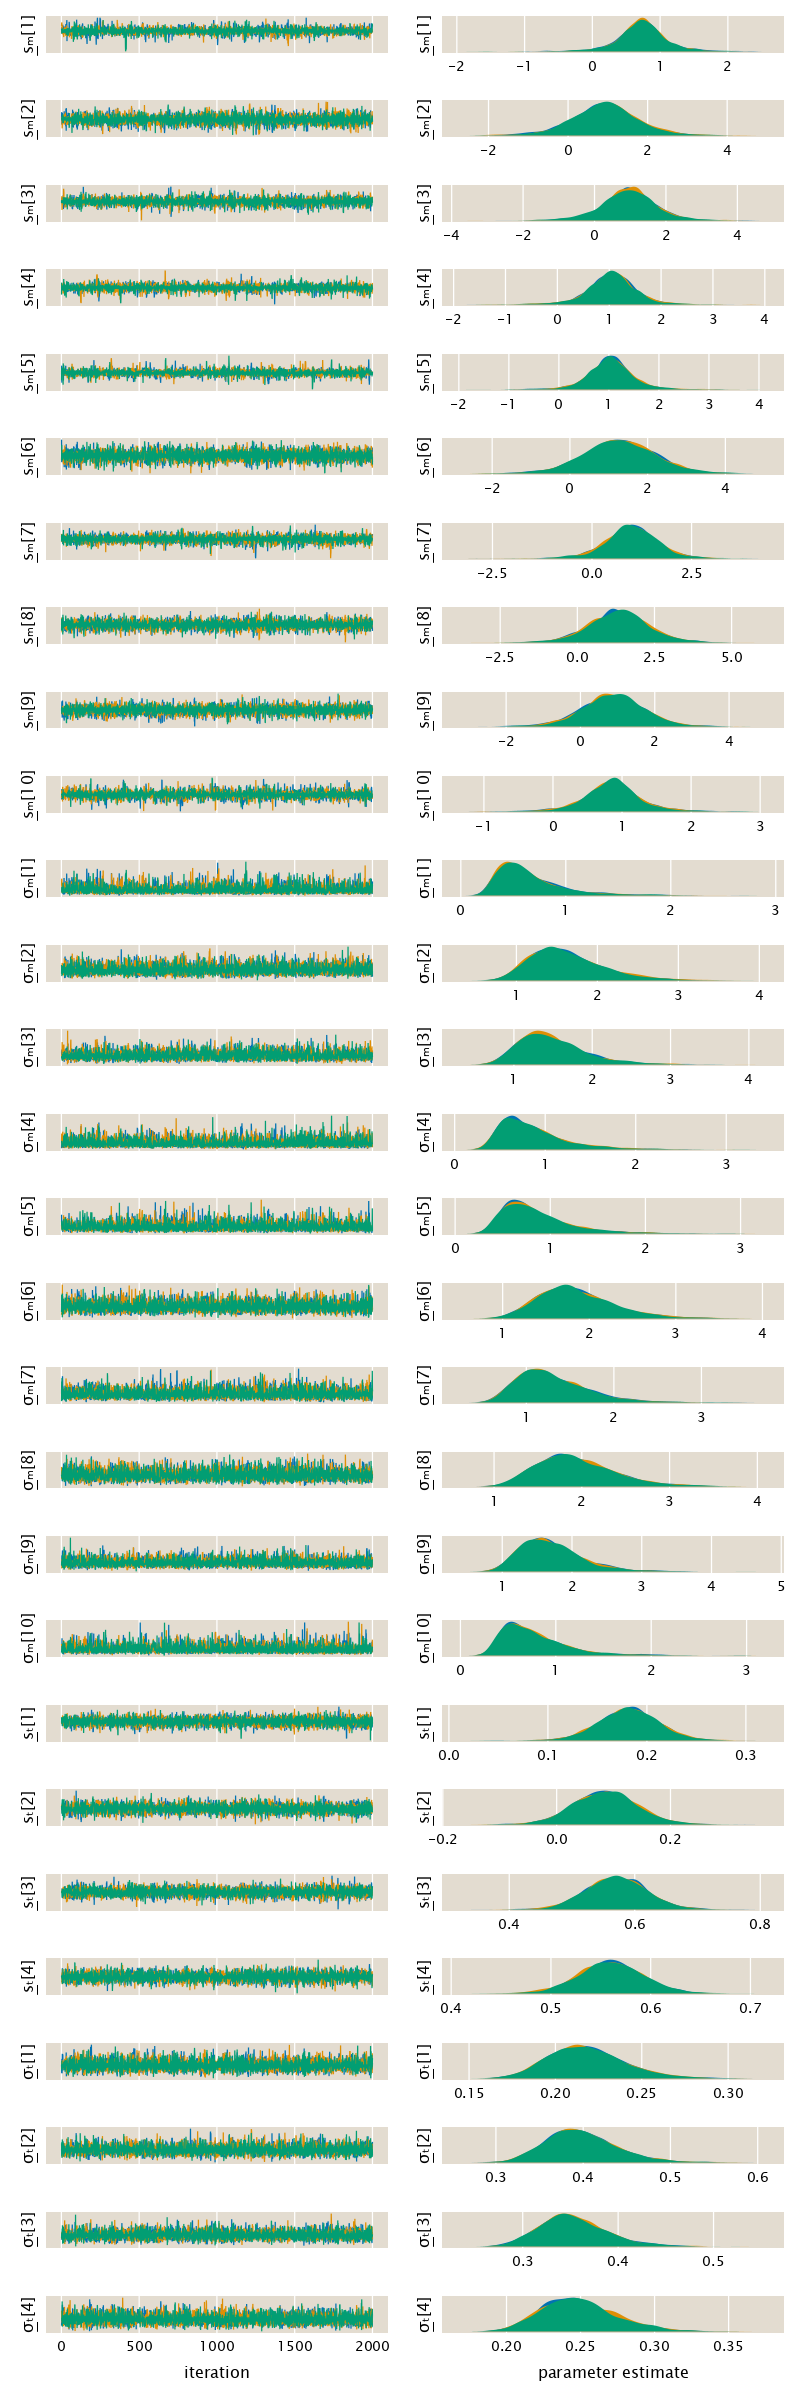

In [37]:
# Extract parameters
params = names(chain, :parameters)

# Extract number of chains
n_chains = length(MCMCChains.chains(chain))
# Extract number of parameters
n_samples = length(chain)

# Initialize figure
fig = Figure(resolution=(800, 2400))

BayesFitness.viz.mcmc_trace_density!(fig, chain)

fig

## Cauchy 

In [38]:
Turing.@model function fitness_mutants_cauchyprior(
    logf_mut, logf_neutral, t, σ_sm, σ_σm, σ_st, σ_σt
)
    # Define parameter types
    s̲ₘ = Float32[]  # adaptive mutants fitness
    σ̲ₘ = Float32[]  # variance for adaptive mutants fitness likelihood

    s̲ₜ = Float32[]  # population mean fitness vector
    σ̲ₜ = Float32[]  # variance for population mean fitness likelihood

    ## Prior
    
    # Prior on adaptive mutants mean fitness
    s̲ₘ ~ Turing.filldist(Turing.Normal(0, σ_sm), size(logf_mut, 2))
    # Prior on variance for adaptive mutants fitness likelihood
    σ̲ₘ ~ Turing.filldist(
        Turing.truncated(Turing.Cauchy(0, σ_σm); lower=0.0 + eps()), 
        size(logf_mut, 2)
    )

    # Prior on the mean fitness
    s̲ₜ ~ Turing.filldist(Turing.Normal(0, σ_st), length(t))
    # Prior on error 
    σ̲ₜ ~ Turing.filldist(
        Turing.truncated(Turing.Cauchy(0, σ_σt); lower=0.0 + eps()), 
        length(t)
    )
    
    ## Likelihood

    # Population mean fitness
    
    # Loop through neutral lineages
    for j = 1:size(logf_neutral, 2)
        # Define non-infinity indexes
        idx = .!isinf.(logf_neutral[:, j])
        # Sample
        logf_neutral[idx, j] ~ Turing.MvNormal(
            -s̲ₜ[idx], LinearAlgebra.Diagonal(σ̲ₜ[idx] .^2)
        )
    end # for

    # Adaptive mutants fitness
    
     # Loop through mutants lineages
     for j = 1:size(logf_mut, 2)
        # Define non-infinity indexes
        idx = .!isinf.(logf_mut[:, j])
        # Sample
        logf_mut[idx, j] ~ Turing.MvNormal(
            s̲ₘ[j] .- s̲ₜ[idx], 
            LinearAlgebra.I(sum(idx)) .* (σ̲ₘ[j] .^2)
        )
    end # for

    return logf_mut, logf_neutral
end # @model function

fitness_mutants_cauchyprior (generic function with 2 methods)

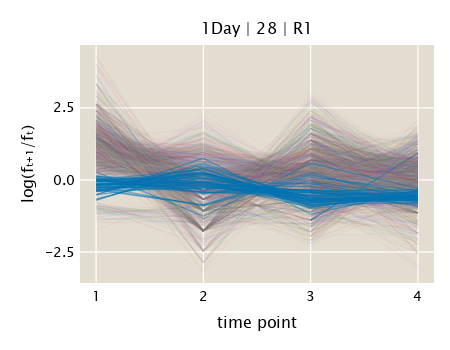

In [39]:
# Define information for data to extract
batch = "Batch1"
hub = "1Day"
perturbation = "28"
rep = "R1"


# Extract data. Note: The time T0 is common to all perturbations, thus, it must
# be extracted separately as a second condition.
data = df[
        (df.hub .== hub) .& 
        (df.batch .== batch) .&
        (df.perturbation .== perturbation) .&
        (df.rep .== rep)
    ,
:]

# Extract total counts per barcode
data_total = DF.combine(DF.groupby(data, :time), :count => sum)
# Add total count column to dataframe
DF.leftjoin!(data, data_total; on=:time)
# Add frequency column
DF.insertcols!(data, :freq => data.count ./ data.count_sum)

# Initialize dataframe to save the log freq changes
data_log = DF.DataFrame()

# Group data by barcode
data_group = DF.groupby(data, :barcode)

# Loop through each group
for d in data_group
    # Compute log change
    DF.append!(
        data_log, 
        DF.DataFrame(
            :barcode .=> first(d.barcode),
            :time => d.time[2:end],
            :logf => diff(log.(d.freq)),
            :neutral .=> first(d.neutral)
        )
    )
end # for

# Extract data for mutants
logf_mut = hcat(
    [
        Float32.(DF.sort(d, :time).logf)
        for d in DF.groupby(data_log[.!data_log.neutral, :], :barcode)
    ]...
)
# Extract data for neutral lineages
logf_neutral = hcat(
    [
        Float32.(DF.sort(d, :time).logf)
        for d in DF.groupby(data_log[data_log.neutral, :], :barcode)
    ]...
)

# Initialize figure
fig = Figure(resolution=(450, 350))

# Add axis
ax = Axis(
    fig[1, 1],
    xlabel="time point",
    ylabel="log(fₜ₊₁/fₜ)",
    title="$(hub) | $(perturbation) | $(rep)"
)

# Define color palette
colors = ColorSchemes.glasbey_hv_n256

# group data by barcode
data_group = DF.groupby(data_log[.!data_log.neutral, :], :barcode)
# Loop through trajectories
for bc in data_group
    # Plot trajectory
    lines!(
        bc.logf,
        color=(colors[StatsBase.sample(1:length(colors))], 0.05)
    )
end # for

# group neutral barcodes by barcode
data_group = DF.groupby(data_log[data_log.neutral, :], :barcode)
# Loop through trajectories
for bc in data_group
    # Plot trajectory
    lines!(
        bc.logf,
        color=(ColorSchemes.seaborn_colorblind[1], 0.5)
    )
end # for

fig

In [40]:
Random.seed!(42)

# Define model
model = fitness_mutants_cauchyprior(
    logf_mut[:, 1:10], 
    logf_neutral, 
    unique(data_log.time), 
    Float32(5.0), 
    Float32(1.0),
    Float32(5.0),
    Float32(1.0),
);

# Suppress warning outputs
Suppressor.@suppress begin
    # Sample
    global chain = Turing.sample(
        model, 
        Turing.NUTS(0.65), 
        Turing.MCMCThreads(),
        2_000, 
        3, 
        progress=false
    )
end

# Print summary stats
Turing.summarystats(chain)

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

       s̲ₘ[1]    0.7258    0.3520     0.0045    0.0065   3625.3548    1.0007    ⋯
       s̲ₘ[2]    0.9213    1.1170     0.0144    0.0189   3161.5769    0.9997    ⋯
       s̲ₘ[3]    0.9652    0.9824     0.0127    0.0160   3542.3782    1.0001    ⋯
       s̲ₘ[4]    1.0486    0.5021     0.0065    0.0083   2777.9894    1.0008    ⋯
       s̲ₘ[5]    1.0282    0.4927     0.0064    0.0077   3346.0871    1.0004    ⋯
       s̲ₘ[6]    1.2353    1.3301     0.0172    0.0234   4025.8642    1.0000    ⋯
       s̲ₘ[7]    1.0080    0.7634     0.0099    0.0117   4370.3955    1.0011    ⋯
       s̲ₘ[8]    1.2547    1.3918     0.0180    0.0241   3448.3246    1.0014    ⋯
       s̲ₘ[9]    0.8669    1.2029     0.0155    0.0189   3570.7405    0.9998    ⋯
      s̲ₘ[10]    0.8555    0.4706     0.0061    0.0088   3190.8519    0.9999    

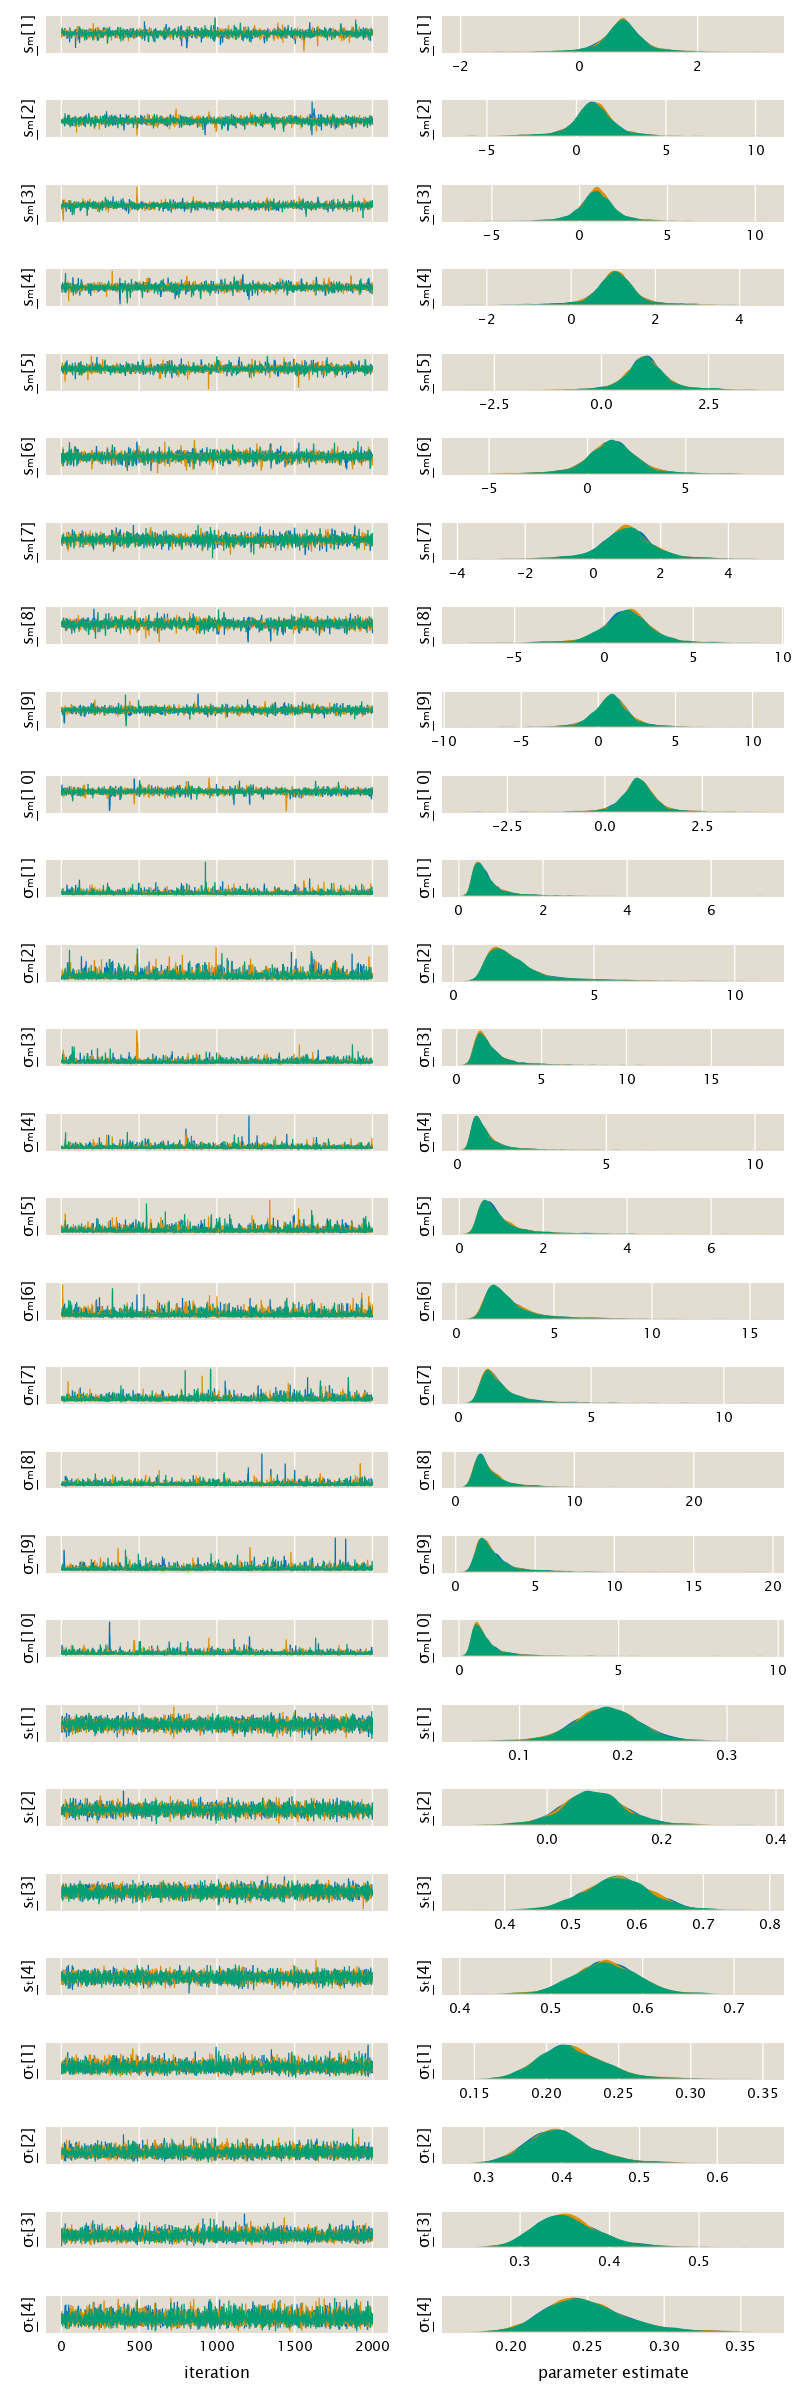

In [41]:
# Extract parameters
params = names(chain, :parameters)

# Extract number of chains
n_chains = length(MCMCChains.chains(chain))
# Extract number of parameters
n_samples = length(chain)

# Initialize figure
fig = Figure(resolution=(800, 2400))

BayesFitness.viz.mcmc_trace_density!(fig, chain)

fig

# Two-step inference

The inference of the entire dataset with > 4000 mutants does not scale properly,
even though, sampling for a few mutants is almost instantaneous. But we can take
advantage of the structure of our problem.